In [1]:
import os
from PIL import Image

import time
import numpy as np
import tensorflow as tf
import pandas as pd


from user import User
from average import Average
from tensorflow import keras

from graphing import *
from file_related import *
from inits import *
from trainers import *
SEED = 0

# import os
# os.environ['PYTHONHASHSEED']=str(SEED)
# np.random.seed(SEED)
# import random
# random.seed(SEED)
# tf.set_random_seed(SEED)
# could need to force keras to not use parallelism, see documentation

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
VALID_IMAGE_EXTENSIONS = [".jpg", ".jpeg", ".png"] # valid extensions

def load_image(infilename):
    img = Image.open(infilename)
    img = img.resize((80,80))
    data = np.asarray(img)
    return data


    
def save_image(np_array, output_filename) :
    im = Image.fromarray(np_array, "RGB")
    im.save(output_filename)     
    
def map_images(data_dir):
    files = {}
    CLASSES = {}

    for class_id, class_dir in enumerate(os.listdir(data_dir)):
        class_name = class_dir
        class_dir = os.path.join(data_dir, class_dir)
        files[class_id] = []
        CLASSES[class_id] = class_name
        for file in os.listdir(class_dir):

            ext = os.path.splitext(file)[1]
            if ext in VALID_IMAGE_EXTENSIONS:

                np_im = load_image(os.path.join(class_dir,file))
                files[class_id].append(np_im)
#                 save_image(np_im,"i.jpg")
        print(f"Done: {class_dir}")
    return CLASSES, files

# https://www.kaggle.com/prasunroy/natural-images/kernels
data_dir = "../testing/data/natural_images/"

CLASSES, files = map_images(data_dir)

Done: ../testing/data/natural_images/airplane
Done: ../testing/data/natural_images/car
Done: ../testing/data/natural_images/cat
Done: ../testing/data/natural_images/dog
Done: ../testing/data/natural_images/flower
Done: ../testing/data/natural_images/fruit
Done: ../testing/data/natural_images/motorbike
Done: ../testing/data/natural_images/person


In [3]:

SEED = 0
def init_users_image(files,  averaging_metric="accuracy", test_size = 0.2, val_size = 0.2, shape=(80,80,3), seed=None):
    users = {}
    keys = list(files.keys())
    
    # initialise users
    for class_id in keys:
        model = init_conv_model(keys, shape)

        option = np.random.RandomState(seed).randint(0,len(averaging_methods))
        users[class_id] = User(user_id=class_id,
                  model = model,
                  averaging_method = averaging_methods[option],
                  averaging_metric = averaging_metric,
                  train_class = None,
                  train_data = None,
                  val_class = None,
                  val_data = None, 
                  test_class = None,
                  test_data = None)
    
    # for class ids in keys, we will now create a majority and rest (of the data) split
    
    for class_id in keys:
        images = np.asarray(files[class_id]).astype("float32")
        # shuffle first pls
        majority_data, rest_data = np.split(images, [int(0.7 * len(images))])
        rest_data_split = np.array_split(rest_data,len(keys)-1)  
        
        rest_data_index = 0
        for user_id in keys:
            if user_id == class_id:
                train_data, train_class, test_data, test_class, val_data, val_class = \
                    train_test_val_split(majority_data, class_id, test_size, val_size)
            else:
                raw_data = rest_data_split[rest_data_index]
                train_data, train_class, test_data, test_class, val_data, val_class = \
                    train_test_val_split(raw_data, class_id, test_size, val_size)
                rest_data_index += 1
                
            if class_id == 0:
                users[user_id].set_test_class(test_class)
                users[user_id].set_test_data(test_data)
                users[user_id].set_val_data(val_data)
                users[user_id].set_val_class(val_class)
                users[user_id].set_train_data(train_data)
                users[user_id].set_train_class(train_class)
            else:
                users[user_id].add_test_class(test_class)
                users[user_id].add_test_data(test_data)
                users[user_id].add_val_data(val_data)
                users[user_id].add_val_class(val_class)
                users[user_id].add_train_data(train_data)
                users[user_id].add_train_class(train_class)
    return users

def train_test_val_split(np_data, class_id, test_size, val_size):
    test_data, train_data = np.split(np_data, [int(test_size * len(np_data))])
    val_size = val_size/(1-test_size)
    val_data, test_data = np.split(test_data, [int(val_size * len(test_data))])
    
    train_class = np.full((train_data.shape[0]),class_id)
    test_class = np.full((test_data.shape[0]),class_id)
    val_class = np.full((val_data.shape[0]),class_id)
#     print(f"              {val_class.shape[0] == val_data.shape[0]}")
    return train_data, train_class, test_data, test_class, val_data, val_class
        
averaging_methods = [Average.all,Average.std_dev,Average.weighted_avg]
      

#     global_user = User()


W0126 23:25:05.772799  8400 deprecation.py:506] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
ROUNDS = 10
EPOCHS = 6
users = init_users_image(files)
train_fed(users = users, rounds = ROUNDS,
          epochs = EPOCHS,
          strat = "central",
          train_user_verbose = False,
          train_user_verbose_evaluate = False,
          train_user_verbose_fit = False,
          averaging_method = Average.all,
          averaging_post = True,
          averaging_metric = "accuracy")

********************************  0   ********************************
0 [2.0734798661593734, 0.05172414]
1 [2.0518303035844303, 0.7234042]
2 [2.058541052269213, 0.045454547]
3 [2.0772714907662913, 0.05263158]
4 [2.0644806027412415, 0.046875]
5 [2.0542382929060192, 0.7291667]
6 [2.070395372747406, 0.048780486]
7 [2.030533742237758, 0.72727275]
******************************** DONE ********************************
********************************  1   ********************************
0 [2.090268299497407, 0.05172414]
1 [2.07570632806061, 0.04255319]
2 [2.0714031457901, 0.045454547]
3 [2.1114954488319264, 0.05263158]
4 [2.0816752314567566, 0.046875]
5 [2.078370624118381, 0.041666668]
6 [2.095178276542726, 0.048780486]
7 [2.0241267881193363, 0.72727275]
******************************** DONE ********************************
********************************  2   ********************************
0 [2.089577387119162, 0.05172414]
1 [2.072019992990697, 0.04255319]
2 [2.0649299549333975, 0.0454

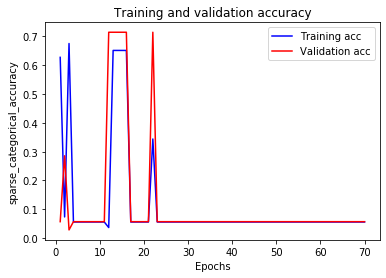

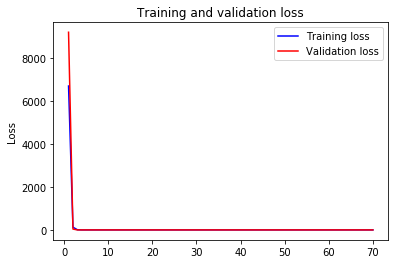

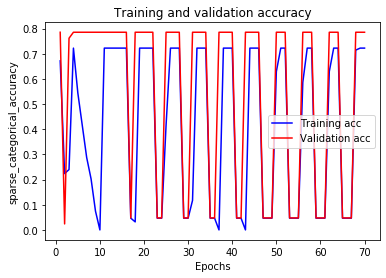

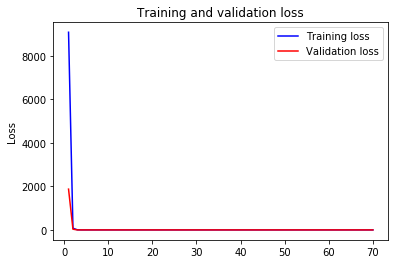

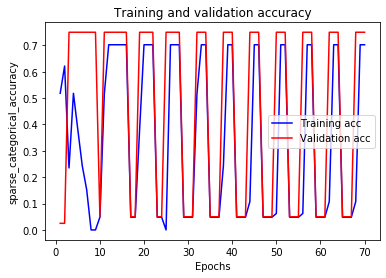

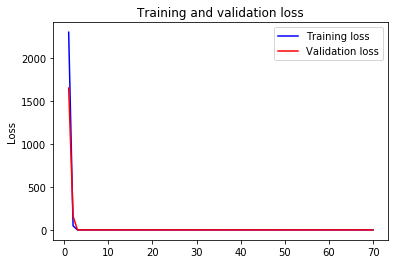

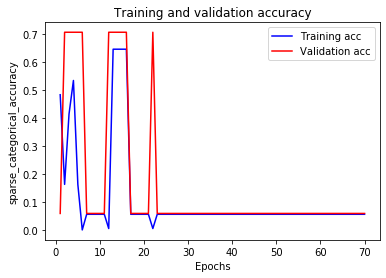

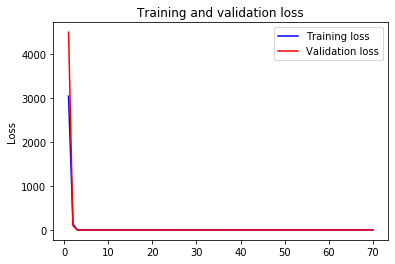

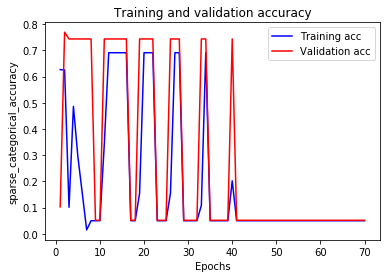

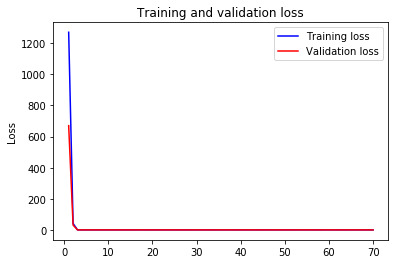

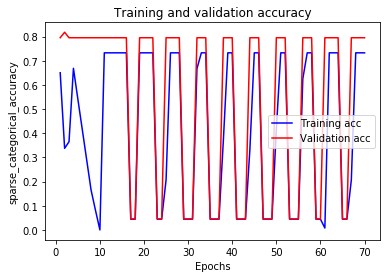

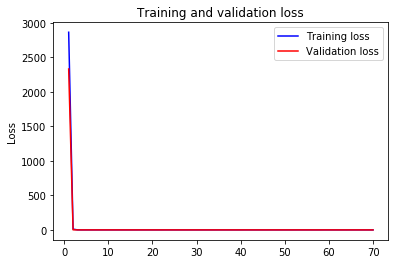

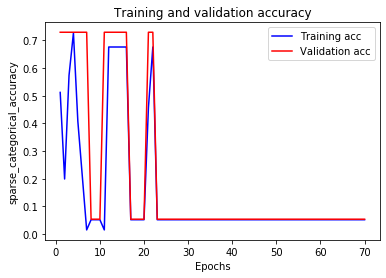

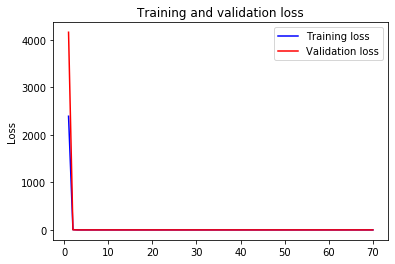

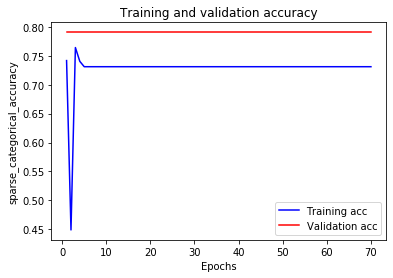

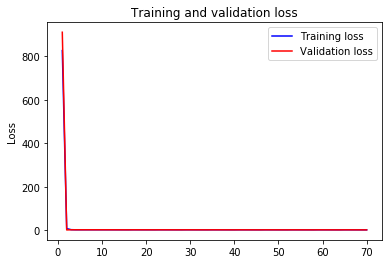

<Figure size 432x288 with 0 Axes>

In [8]:
for i in users.keys():
    draw_graphs(users[i])

Final values for Pre-fit accuracy
Position                    Pre
Round                        19
Average                 0.13212
Standard Deviation     0.224977
Minimum               0.0416667
Maximum                0.727273
Name: 38, dtype: object
Final values for Post-fit accuracy
Position                  Post
Round                       19
Average                0.38555
Standard Deviation    0.335622
Minimum               0.046875
Maximum               0.729167
Name: 39, dtype: object



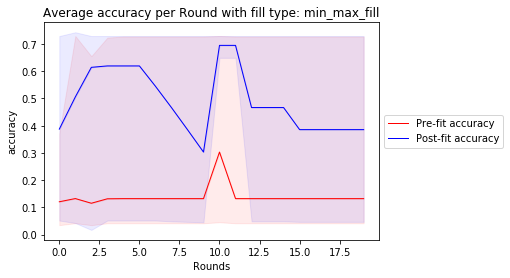

<Figure size 432x288 with 0 Axes>

In [9]:
ignore_first_n = 0
final_values = True
df_avg_round_stats_acc = avg_round_stats(users, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         metric = "accuracy",
                                         final_values = final_values)